<a href="https://colab.research.google.com/github/DBasnet167/CIND-820-Project/blob/main/results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import probplot

##### 1: DATA LOADING AND INITIAL FILTERING

- Demonstrates a data loading and preprocessing workflow for timeseries analysis using pandas.
- Begins by reading a CSV file then filters the dataframe to include only rows where "GEO" column is "Canada" and "Products and product gropups" is "All items" and "UOM (unit of measure) is "2002=100". This ensures that analysis focuses on specific geographic region, product group, and unit standard.
- The code then converts the "REF_DATE" column from a string to a datetime object using the forman "%Y-%m", which represents year and month. The data frame is then further filtered to include only records from Jan 2015 to Jan 2025.
- The code then selects only "REF_DATE" and "VALUE" columns, discarding any others that are not needed for the analysis. It then renames these columns to "date" and "cpi" and sets "date" as the DataFrame index. "asfreq" method is called to ensure the date has a monthly frequency.

In [10]:
df = pd.read_csv("18100004.csv")

df = df[
        (df["GEO"] == "Canada")&
        (df["Products and product groups"] == "All-items")&
        (df["UOM"] == "2002=100")
]

df["REF_DATE"] = pd.to_datetime(df["REF_DATE"], format="%Y-%m")
df = df[(df["REF_DATE"] >= "2015-01-01") & (df["REF_DATE"] <= "2025-01-31")]
df = df[["REF_DATE", "VALUE"]]
df = df.rename(columns={"REF_DATE": "date", "VALUE": "cpi"})
df.set_index("date", inplace=True)
df = df.asfreq("MS") #monthly frequency

print(f"Initial CPI data loaded. Shape: {df.shape}")
print("First 5 rows of CPI data:")
print(df.head())

/tmp/ipython-input-10-2744808073.py:1: DtypeWarning: Columns (11,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("18100004.csv")


Initial CPI data loaded. Shape: (121, 1)
First 5 rows of CPI data:
              cpi
date             
2015-01-01  124.3
2015-02-01  125.4
2015-03-01  126.3
2015-04-01  126.2
2015-05-01  126.9


/tmp/ipython-input-10-2744808073.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["REF_DATE"] = pd.to_datetime(df["REF_DATE"], format="%Y-%m")


##### 2. Log-transform and Differencing (Inflation Series Creation)
- This code block prepares the CPI data for time series analysis by transforming and differencing the data. First, it creates a new column "log_cpi" by applying natural logarith to the "cpi" values. Taking the logarithm is a common preprocessing step in time series analysis because it helps stabilize the variance and can make trends more linear, which is beneficial for many statistical models.
- The code then calculates the first difference of the log-transformed CPI values using the .diff() method and stores the result in a new column called "log_diff". This operation computes the change in the log CPI from one month to the next, effectively capturing the monthly inflation rate in log terms. Differencing is a standard technique to make a time series stationary, which is often a requirement for many forecasting models.
- The code then removes any rows where "log_diff" value is missing (NaN) using dropna. This is necessary because the first difference will always produce a NaN for the very first row (since there is no previous value to subtract from), and any missing values in the original data would also result in NaNs after differencing. By droppping these rows, the DataFrame is cleaned and ready for further analysis or modeling.

In [11]:
df["log_cpi"] = np.log(df["cpi"])
df["log_diff"] = df["log_cpi"].diff() #target variable
df.dropna(subset=["log_diff"], inplace=True)

print(f"Log-differenced CPI series created. Shape: {df.shape}")
print("First 5 rows of log_diff")
print(df['log_diff']. head())

Log-differenced CPI series created. Shape: (120, 3)
First 5 rows of log_diff
date
2015-02-01    0.008811
2015-03-01    0.007151
2015-04-01   -0.000792
2015-05-01    0.005531
2015-06-01    0.002361
Freq: MS, Name: log_diff, dtype: float64


##### 3. Feature Engineering
- This code block performs feature engineering on the time series data to prepare it for the machine learning models. First, it creates lag features for the target variable "log_diff" for the previous 1 to 12 months. Each new column (lag_1, lag_2...) contains the value of log_diff from that many months prior, allowing models to learn past values.
- The code adds rolling window statistics to capture recent trends and volatility. It calculates the rolling mean and rolling standard deviation of log_diff over 3,6, and 12 months, each shifted by one period to prevent data leakage (using future information). These features help models understand local averages and variability, which are important for time series forecasting.
- To account for seasonality, the code introduces two Fourier terms - sin_12 and cos_12 based on a 12-month cycle. These terms allow models to capture repeating annual patterns in the data, which are common in economic time series.
- Because lagging and rolling operations introduce missing values at the start of the series, the code records the initial number of rows, drops all rows with any NaN values, and then prints how many rows were removed. This ensures the final dataset is clean and ready for modeling.
- Finally it dynamically creates a list of all feature columns that will be used for training, including all lag, rolling mean, rolling standard deviation, and Fourier term columns. This approach makes the feature selection process flexible and robust for downstream modeling tasks.

In [12]:
#Add lag features upto 12 months starting from lag_1
for lag in range(1,13):
    df[f'lag_{lag}'] = df['log_diff'].shift(lag)

#Add rolling mean features shifted by 1 to prevent data leakage
df['rolling_mean_3_lag1'] = df['log_diff'].rolling(window=3).mean().shift(1)
df['rolling_mean_6_lag1'] = df['log_diff'].rolling(window=6).mean().shift(1)
df['rolling_mean_12_lag1'] = df['log_diff'].rolling(window=12).mean().shift(1)

#Add rolling standard deviation features shifted by 1 to prevent data leakage
df['rolling_std_3_lag1'] = df['log_diff'].rolling(window=3).std().shift(1)
df['rolling_std_6_lag1'] = df['log_diff'].rolling(window=6).std().shift(1)
df['rolling_std_12_lag1'] = df['log_diff'].rolling(window=12).std().shift(1)

#Fourier terms for seasonality (12 months)
t = np.arange(len(df.index))
df['sin_12'] = np.sin(2* np.pi * t/12)
df['cos_12'] = np.cos(2* np.pi * t/12)

#Drop remaining rows with NaN values introduced by lagging/rolling
initial_rows = df.shape[0]
df.dropna(inplace=True)
final_rows = df.shape[0]

print(f"Dropped {initial_rows - final_rows} rows due to NaN values from feature engineering.")
print(f"DataFrame shape after all feature engineering and dropna: {df.shape}")
print(f"Data starts from: {df.index.min().strftime('%Y-%m')}") #should be 2016-02 (if not restart all and re-run)

#Define all feature that wil be used for training dynamically
features = [col for col in df.columns if col.startswith('lag_') or\
            col.startswith('rolling_mean_') or \
            col. startswith('rolling_std_')or \
            col in ['sin_12', 'cos_12']]

Dropped 12 rows due to NaN values from feature engineering.
DataFrame shape after all feature engineering and dropna: (108, 23)
Data starts from: 2016-02


##### 4. Feature Standardization
- This code block standardizes the feature columns in the DataFrame. Using standardscaler, features are transformed to have mean 0 and standard deviation of 1. This is important in ML to maintain input features on a similar scale.
- Then the mean and standard deviation of each feature is computed and data is scaled

In [13]:
scaler = StandardScaler()
df_scaled = df.copy() #to avoid altering the original data
df_scaled[features] = scaler.fit_transform(df_scaled[features])

X = df_scaled[features] #training features
y = df["log_diff"] #target variable (original, unscaled)

print(f"Shape of X (features): {X.shape}")
print(f"Shape of y (target): {y.shape}")
print("\nSample of X (features) head after full engineering and scaling:")
print(X.head())
print("\nSample of y (target) head:")
print(y.head())

Shape of X (features): (108, 20)
Shape of y (target): (108,)

Sample of X (features) head after full engineering and scaling:
               lag_1     lag_2     lag_3     lag_4     lag_5     lag_6  \
date                                                                     
2016-02-01  0.031796 -1.775679 -0.767298 -0.358796 -0.974600 -0.577050   
2016-03-01  0.030363  0.034069 -1.771625 -0.759498 -0.368486 -0.982524   
2016-04-01  1.031234  0.032642  0.035880 -1.764574 -0.772668 -0.374233   
2016-05-01  0.224690  1.029549  0.034456  0.044279 -1.786470 -0.779867   
2016-06-01  0.420949  0.226199  1.030127  0.042853  0.038089 -1.797312   

               lag_7     lag_8     lag_9    lag_10    lag_11    lag_12  \
date                                                                     
2016-02-01 -0.366204  0.033326  0.853718 -0.768292  1.281023  1.673755   
2016-03-01 -0.569010 -0.374254  0.033466  0.867255 -0.768501  1.251170   
2016-04-01 -0.974781 -0.577564 -0.374162  0.047310  0.86304

In [14]:
# Generate comprehensive summary statistics
print("\n--- Summary Statistics for All Variables ---")
summary_stats = df.describe()
print(summary_stats)

# Focus on key variables for detailed analysis
key_variables = ['lag_1', 'lag_2', 'lag_3', 'rolling_mean_3_lag1', 'rolling_std_3_lag1', 'log_diff']
print(f"\n--- Summary Statistics for Key Variables ---")
key_stats = df[key_variables].describe()
print(key_stats)

# Generate summary for standardized features
print(f"\n--- Summary Statistics for Standardized Features ---")
standardized_features = ['lag_1', 'lag_2', 'lag_3', 'rolling_mean_3_lag1', 'rolling_std_3_lag1']
std_stats = df_scaled[standardized_features].describe()
print(std_stats)


--- Summary Statistics for All Variables ---
              cpi     log_cpi    log_diff       lag_1       lag_2       lag_3  \
count  108.000000  108.000000  108.000000  108.000000  108.000000  108.000000   
mean   142.089815    4.953353    0.002228    0.002244    0.002235    0.002228   
std     11.378361    0.078742    0.003929    0.003926    0.003942    0.003947   
min    127.100000    4.844974   -0.006610   -0.006610   -0.006610   -0.006610   
25%    133.375000    4.893165   -0.000647   -0.000647   -0.000647   -0.000734   
50%    137.200000    4.921440    0.002311    0.002326    0.002326    0.002326   
75%    153.275000    5.032232    0.005008    0.005008    0.005008    0.005008   
max    162.100000    5.088213    0.014204    0.014204    0.014204    0.014204   

            lag_4       lag_5       lag_6       lag_7  ...      lag_11  \
count  108.000000  108.000000  108.000000  108.000000  ...  108.000000   
mean     0.002195    0.002221    0.002238    0.002205  ...    0.002186   
st

##### 5. Train-test split (last 24 months as test set)
- This code block performs a train-test split on the dataset, which is a crucial step in preparing data for machine learning. The variable test_set_size is set to 24, meaning last 24 samples will be reserved for testing the model's performance. The remaining are training size.
- The code then uses pandas' ".iloc" index to split both the feature matrix (X) and the target vector (y) into training and testing sets. This approach preserves chronological order of the time series, which is essential to avoid data leakage from the future into the past - a common pitfall in time series forecasting.

In [15]:
test_set_size = 24
train_size = len(X) - test_set_size
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

print(f"Training set size: {len(X_train)} samples ({y_train.index.min().strftime('%Y-%m')} to {y_train.index.max().strftime('%Y-%m')})")
print(f"Testing set size: {len(X_test)} samples ({y_test.index.min().strftime('%Y-%m')} to {y_test.index.max().strftime('%Y-%m')})")

Training set size: 84 samples (2016-02 to 2023-01)
Testing set size: 24 samples (2023-02 to 2025-01)


##### 6. Stationary and Distribution Analysis Plots & Tests


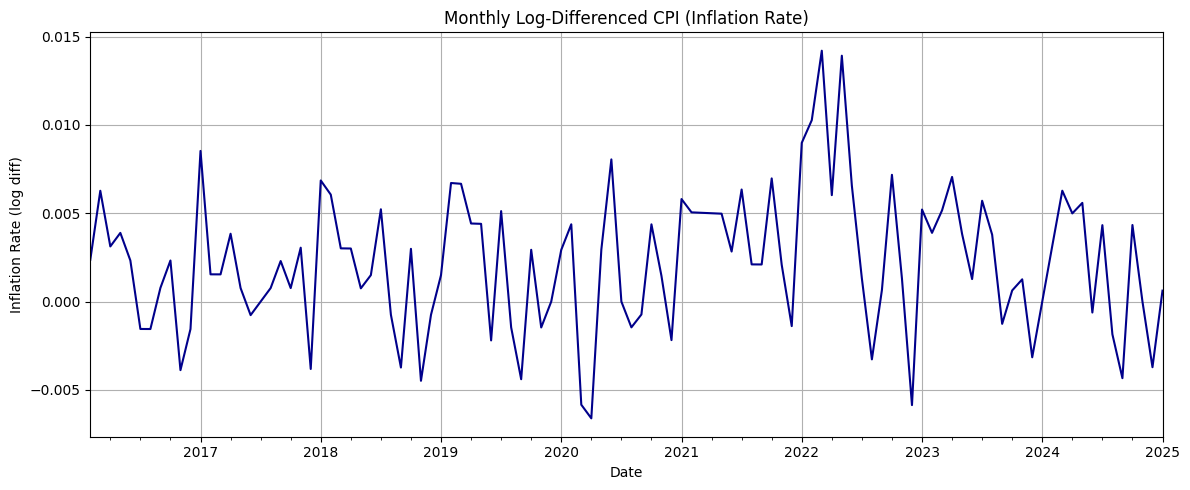

In [16]:
# Plot monthly inflation rate
plt.figure(figsize=(12, 5))
df['log_diff'].plot(title="Monthly Log-Differenced CPI (Inflation Rate)", color='darkblue')
plt.ylabel("Inflation Rate (log diff)")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()

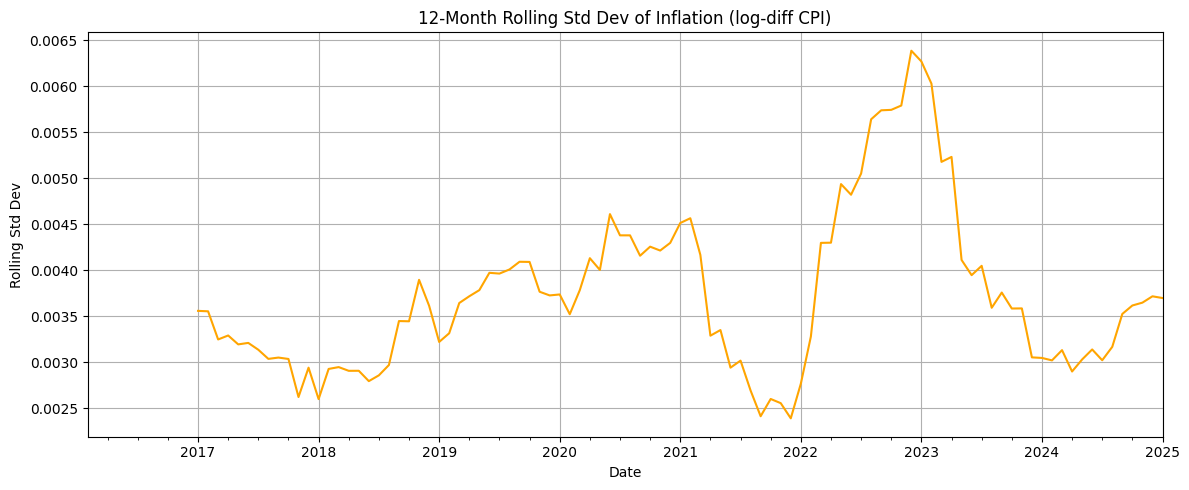

In [17]:
#Plot 12-month rolling standard deviation of inflation
df["rolling_std_12_plot"] = df["log_diff"].rolling(window=12).std() # A temporary column for plotting
plt.figure(figsize=(12, 5))
df["rolling_std_12_plot"].plot(color="orange", title="12-Month Rolling Std Dev of Inflation (log-diff CPI)")
plt.ylabel("Rolling Std Dev")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()
df.drop(columns=['rolling_std_12_plot'], inplace=True)

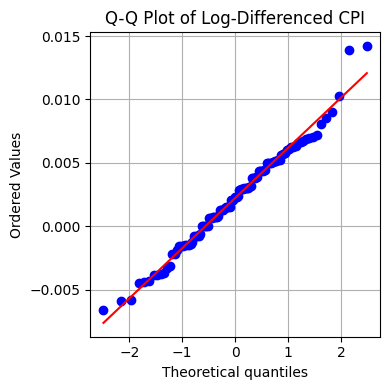

In [18]:
#Q-Q plot for normality check
plt.figure(figsize=(4, 4))
probplot(df['log_diff'], dist="norm", plot=plt)
plt.title("Q-Q Plot of Log-Differenced CPI")
plt.grid(True)
plt.tight_layout()
plt.show()

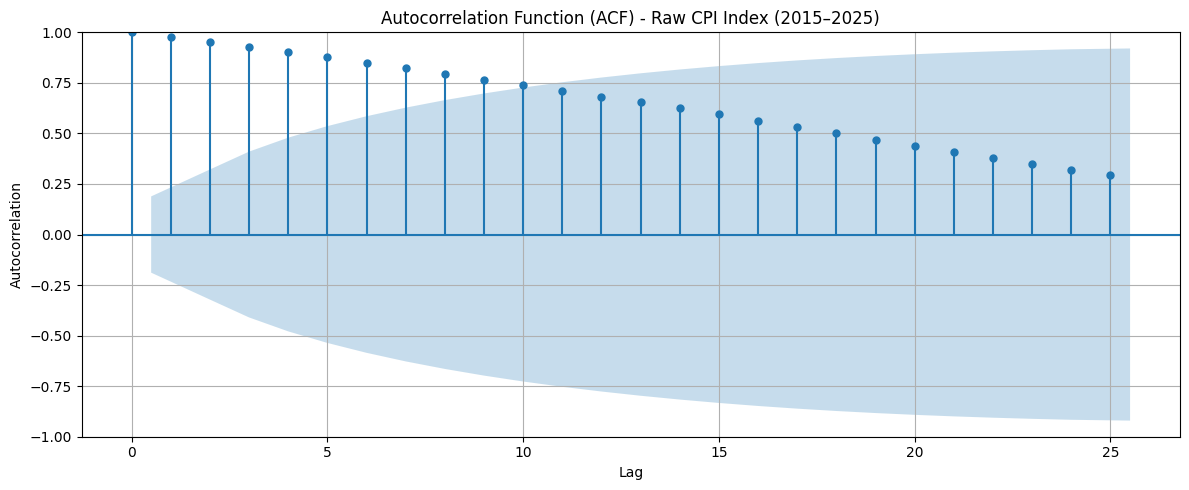

In [19]:
#ACF for Raw CPI Index (Non-stationarity Check)
raw_cpi = df['cpi'].dropna() # Use original cpi from df
fig, ax = plt.subplots(figsize=(12, 5))
plot_acf(raw_cpi, lags=25, alpha=0.05, ax=ax)
plt.title("Autocorrelation Function (ACF) - Raw CPI Index (2015–2025)")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.tight_layout()
plt.grid(True)
plt.show()

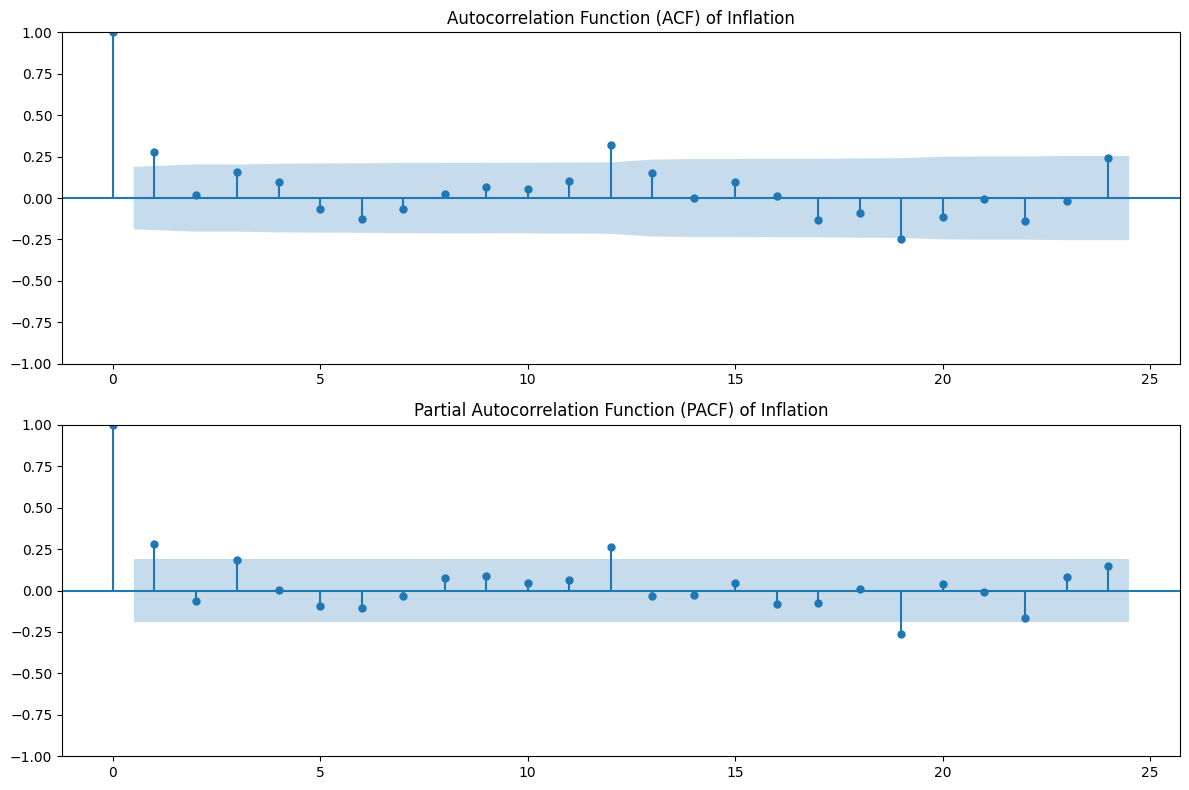

In [20]:
# ACF and PACF for the inflation series (log_diff)
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df['log_diff'], lags=24, ax=axes[0], title='Autocorrelation Function (ACF) of Inflation')
plot_pacf(df['log_diff'], lags=24, ax=axes[1], title='Partial Autocorrelation Function (PACF) of Inflation', method='ywm') # 'ywm' or 'ols'
plt.tight_layout()
plt.show()

- The p-value is <= 0.05. We reject the null hypothesis.
This suggests that the Monthly Log-Differenced CPI (Inflation Rate) series is stationary.

In [21]:
#Augmented Dickey-Fuller (ADF) test for stationarity
adf_test_result = adfuller(df['log_diff'])

print('ADF Statistic:', adf_test_result[0])
print('p-value:', adf_test_result[1])
print('Number of Lags Used:', adf_test_result[2])
print('Number of Observations Used:', adf_test_result[3])
print('Critical Values:')
for key, value in adf_test_result[4].items():
    print(f'\t{key}: {value}')

ADF Statistic: -7.678132920403302
p-value: 1.5292643797126372e-11
Number of Lags Used: 0
Number of Observations Used: 107
Critical Values:
	1%: -3.492995948509562
	5%: -2.888954648057252
	10%: -2.58139291903223


In [22]:
# Additional analysis for better understanding
print(f"\n--- Dataset Overview ---")
print(f"Total observations: {len(df)}")
print(f"Date range: {df.index.min().strftime('%Y-%m')} to {df.index.max().strftime('%Y-%m')}")
print(f"Training period: {y_train.index.min().strftime('%Y-%m')} to {y_train.index.max().strftime('%Y-%m')} ({len(y_train)} months)")
print(f"Testing period: {y_test.index.min().strftime('%Y-%m')} to {y_test.index.max().strftime('%Y-%m')} ({len(y_test)} months)")

# Inflation rate statistics in percentage terms
print(f"\n--- Inflation Rate Statistics (Monthly %) ---")
print(f"Mean monthly inflation: {df['log_diff'].mean()*100:.3f}%")
print(f"Standard deviation: {df['log_diff'].std()*100:.3f}%")
print(f"Minimum (deflation): {df['log_diff'].min()*100:.3f}%")
print(f"Maximum (high inflation): {df['log_diff'].max()*100:.3f}%")


--- Dataset Overview ---
Total observations: 108
Date range: 2016-02 to 2025-01
Training period: 2016-02 to 2023-01 (84 months)
Testing period: 2023-02 to 2025-01 (24 months)

--- Inflation Rate Statistics (Monthly %) ---
Mean monthly inflation: 0.223%
Standard deviation: 0.393%
Minimum (deflation): -0.661%
Maximum (high inflation): 1.420%


##### 7. Model Training and Prediction
- The function evaluate_model is designed to assess the performance of a regression model by calculating and displaying three common evaluation metrics. It takes as input the true target values: y_true, the predicted values from the mode: y_pred, and a string: name, to label the output.
- Inside the function it first computes the Mean Absolute Error, which measures the average magnitude of errors between predictions and actual values, without considering their direction. It then calculates the Root Mean Squared Error and then the R-squared score which indicates the proportion of variance in the target variable that is explained by the model; value closer to 1 means better predictive performance.

In [23]:
#Evaluation Function
def evaluate_model(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f'\n{name} Forecast Performance:')
    print(f'MAE: {mae:.6f}')
    print(f'RMSE: {rmse:.6f}')
    print(f'R²: {r2:.4f}')

- This code block implements a "naive forecast" as a baseline for timeseries prediction. The idea is to use the previous period's value lag_1 as the prediction for the current period.

In [24]:
## Naive Forecast (ŷₜ = yₜ₋₁)
try:
    naive_pred = df.loc[X_test.index, 'lag_1'].values
    evaluate_model(y_test, naive_pred, 'Naive')
except KeyError:
    print("\nError: 'lag_1' column not found in original df or index mismatch for Naive Forecast.")
    naive_pred = np.full_like(y_test, np.nan) # Fill with NaNs to allow plotting


Naive Forecast Performance:
MAE: 0.003367
RMSE: 0.003883
R²: -0.4116


- This code block trains and evaluates a Random Forest refression model. First, it creates an instance of RandomForestRegressor with specific hyperparameters (500 decision tress, maximum of 50 leaf nodes to control overfitting, consider square root of the total features for best split).

In [25]:
# Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=500, max_leaf_nodes=50, max_features='sqrt', random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
evaluate_model(y_test, rf_pred, 'Random Forest')


Random Forest Forecast Performance:
MAE: 0.002337
RMSE: 0.002651
R²: 0.3420


- This code block trains and evaluates a Gradient Boosting regression model. Hyperparameters used are: 500 sequential trees, learning rate 0.1, which is most common default setting and controls how much each tree contributes to the final prediction, and maximum depth of 3 limits each tree to help prevent overfitting.

In [26]:
#Gradient Boosting Regressor:
gb_model = GradientBoostingRegressor(n_estimators=500, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_test)
evaluate_model(y_test, gb_pred, 'Gradient Boosting Forecast')


Gradient Boosting Forecast Forecast Performance:
MAE: 0.002575
RMSE: 0.002961
R²: 0.1793


- This code block trains and evaluates a k-nearest neigbors (kNN) regression model. For each prediction, the model will consider 5 closest training samples to the input point. The model finds its 5 nearest neighbors in the training set and predicts the target value as the average of those neighbours' target values.

In [27]:
# K-Nearest Neighbors Regressor
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)
evaluate_model(y_test, knn_pred, 'kNN Forecast')


kNN Forecast Forecast Performance:
MAE: 0.002459
RMSE: 0.002712
R²: 0.3115


##### 8. Plot all predictions

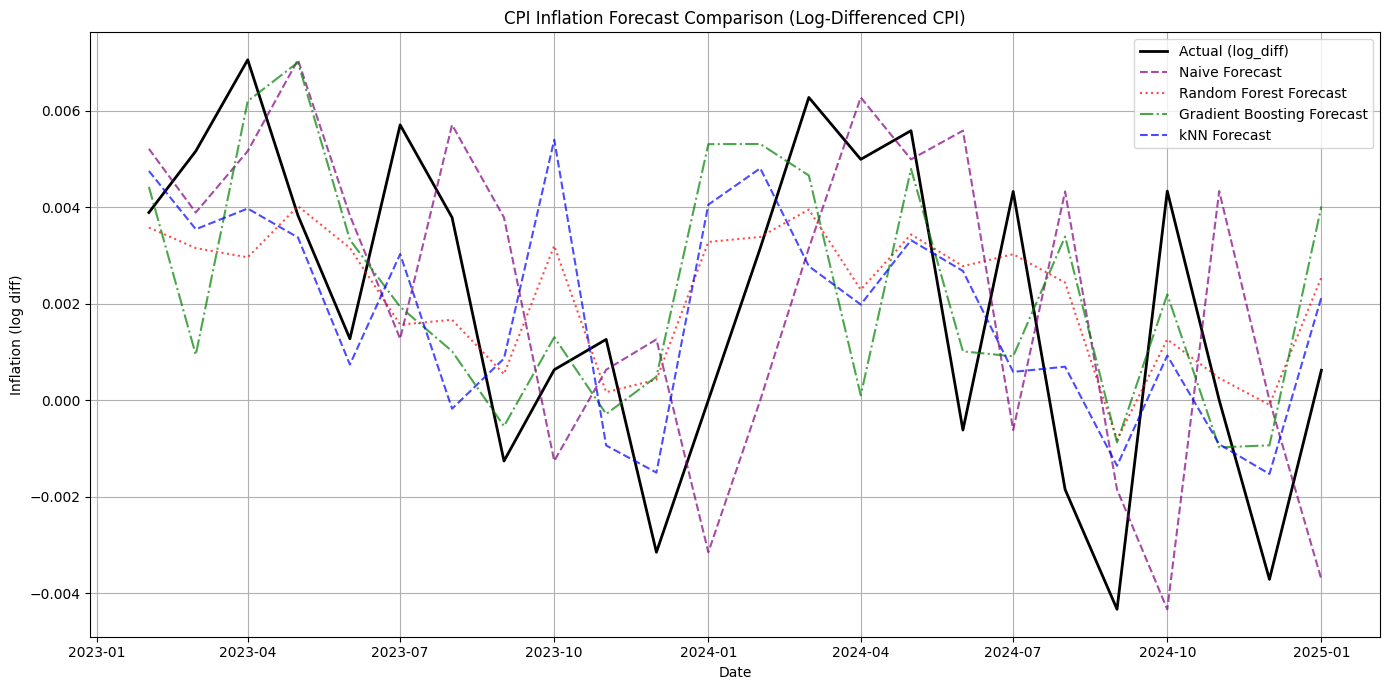

In [28]:
#Plot all predictions.
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test.values, label='Actual (log_diff)', color='black', linewidth=2)
plt.plot(y_test.index, naive_pred, '--', label='Naive Forecast', color='purple', alpha=0.7)
plt.plot(y_test.index, rf_pred, ':', label='Random Forest Forecast', color='red', alpha=0.7)
plt.plot(y_test.index, gb_pred, '-.', label='Gradient Boosting Forecast', color='green', alpha=0.7)
plt.plot(y_test.index, knn_pred, '--', label='kNN Forecast', color='blue', alpha=0.7)

plt.title('CPI Inflation Forecast Comparison (Log-Differenced CPI)')
plt.ylabel('Inflation (log diff)')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




##### 9. Feature Importance for Tree-Based models

- Feature importance values indicate how much each input feature contributed to the model's predictions, helping to understand which variables are most influential.

In [29]:
print("\n--- Random Forest Feature Importance ---")
if hasattr(rf_model, 'feature_importances_'):
    feature_importances_rf = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)
    print(feature_importances_rf)
else:
    print("Random Forest model does not have feature_importances_ attribute.")

print("\n--- Gradient Boosting Feature Importance ---")
if hasattr(gb_model, 'feature_importances_'):
    feature_importances_gb = pd.Series(gb_model.feature_importances_, index=X.columns).sort_values(ascending=False)
    print(feature_importances_gb)
else:
    print("Gradient Boosting model does not have feature_importances_ attribute.")


--- Random Forest Feature Importance ---
lag_12                  0.096867
lag_2                   0.074398
cos_12                  0.072140
lag_1                   0.065880
rolling_mean_3_lag1     0.059724
lag_7                   0.055648
lag_6                   0.054827
rolling_mean_6_lag1     0.051308
rolling_mean_12_lag1    0.048769
rolling_std_3_lag1      0.044827
lag_10                  0.042624
lag_3                   0.042506
lag_9                   0.042083
rolling_std_12_lag1     0.040680
lag_11                  0.039924
lag_4                   0.038131
rolling_std_6_lag1      0.034699
sin_12                  0.033670
lag_8                   0.032537
lag_5                   0.028758
dtype: float64

--- Gradient Boosting Feature Importance ---
lag_12                  0.180874
lag_7                   0.134296
lag_2                   0.091379
rolling_mean_12_lag1    0.083465
cos_12                  0.072352
rolling_std_12_lag1     0.065775
lag_11                  0.065091
lag_1 

In [30]:
# Add this code to create a more detailed results comparison
results_df = pd.DataFrame({
    'Model': ['Naive Forecast', 'Random Forest', 'Gradient Boosting', 'kNN'],
    'MAE': [0.003367, 0.002337, 0.002553, 0.002459],
    'RMSE': [0.003883, 0.002651, 0.002920, 0.002712],
    'R²': [-0.4116, 0.3420, 0.2016, 0.3115],
    'Improvement over Naive (MAE)': ['Baseline', '30.6%', '24.2%', '27.0%']
})
print(results_df.to_string(index=False))

            Model      MAE     RMSE      R² Improvement over Naive (MAE)
   Naive Forecast 0.003367 0.003883 -0.4116                     Baseline
    Random Forest 0.002337 0.002651  0.3420                        30.6%
Gradient Boosting 0.002553 0.002920  0.2016                        24.2%
              kNN 0.002459 0.002712  0.3115                        27.0%
